In [69]:
import pandas as pd
import numpy as np

from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator as BLE

from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt
import networkx as nx

from pgmpy.factors.discrete import TabularCPD

In [70]:
def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup
    



In [71]:
class PreprocessDataParameter:
    def __init__(self, NODE_SIZE, NUM_BINS, NUM_BINS_SMALL):
        self.NODE_SIZE = NODE_SIZE
        self.NUM_BINS = NUM_BINS
        self.NUM_BINS_SMALL = NUM_BINS_SMALL
        
    def plot(self, model):
        plt.figure(figsize=(8, 6), dpi=100)  
        
        nx.draw(model, with_labels=True, node_size = self.node_sizes)
        
        plt.axis('off')
        axis = plt.gca()
        axis.set_xlim([1.2*x for x in axis.get_xlim()])
        axis.set_ylim([1.2*y for y in axis.get_ylim()])
        
        return plt.show()

    def get_disc_data(self, disc_data):

        teplota = self.cutting_cond(disc_data['Teplota vzduchu'])
        rychlost = self.cutting_cond(disc_data['Rychlost otáček'])
        krout = self.cutting_cond(disc_data['Kroutící moment'])
        opo = self.cutting_cond(disc_data['Opotřebení nástroje'])
        
        return disc_data, teplota, rychlost, krout, opo
    
    def cutting_cond(self, x):
        return (min(x), max(x), (max(x) - min(x)) / self.NUM_BINS)
    
    def cutting_cond_small(self, x):
        return (min(x) - 100, max(x) + 100, ((max(x) + 100) - (min(x) - 100)) / self.NUM_BINS_SMALL)
    
    def bin_data(self, x_test, data_to_be_replaced = None):
        NUM_BINS = self.NUM_BINS
        NUM_BINS_SMALL = self.NUM_BINS_SMALL
        
        
        disc_data = x_test.copy()
        disc_data, teplota, rychlost, krout, opo = self.get_disc_data(disc_data)
        
        teplota = self.cutting_cond(disc_data['Teplota vzduchu'])
        rychlost = self.cutting_cond(disc_data['Rychlost otáček'])
        krout = self.cutting_cond(disc_data['Kroutící moment'])
        opo = self.cutting_cond_small(disc_data['Opotřebení nástroje'])
        
        disc_data['T'] = pd.cut(x = disc_data['Teplota vzduchu'], bins = np.arange(teplota[0], teplota[1], teplota[2]), labels = np.arange(0, NUM_BINS - 1, 1))
        disc_data['R'] = pd.cut(x = disc_data['Rychlost otáček'], bins = np.arange(rychlost[0], rychlost[1], rychlost[2]), labels = np.arange(0, NUM_BINS - 1, 1))
        disc_data['K'] = pd.cut(x = disc_data['Kroutící moment'], bins = np.arange(krout[0], krout[1], krout[2]), labels = np.arange(0, NUM_BINS - 1, 1))
        disc_data['O'] = pd.cut(x = disc_data['Opotřebení nástroje'], bins = np.arange(opo[0], opo[1], opo[2]), labels = np.arange(0, NUM_BINS_SMALL - 1, 1))

        y_test = disc_data['Porucha']
        disc_data = disc_data.dropna(how = 'any')
        
        return disc_data
    
    
from pgmpy.factors.discrete.CPD import TabularCPD

def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup
    
        

In [77]:
df = pd.read_csv("ai4i2020.csv")
df.columns  = ["a", "b", "c", 'Teplota vzduchu', 'Teplota procesu',  'Rychlost otáček', 'Kroutící moment', 'Opotřebení nástroje', 'Porucha', "q", "q", "q", "q", "q"]

In [78]:
df

,a,b,c,Teplota vzduchu,Teplota procesu,Rychlost otáček,Kroutící moment,Opotřebení nástroje,Porucha,q,q,q,q,q
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [92]:
enc = OrdinalEncoder()
df = pd.read_csv('data/predictive_maintenance.csv')

df = df[['Teplota vzduchu', 'Rychlost otáček', 'Kroutící moment', 'Opotřebení nástroje', 'Porucha']]
df.columns = ['Teplota vzduchu', 'Rychlost otáček', 'Kroutící moment', 'Opotřebení nástroje', 'Porucha']

df[df['Porucha'] == 1].reset_index(drop = True) 

from sklearn.model_selection import train_test_split

_, x_test, _, y_test = train_test_split(
                                          df.loc[:, df.columns != 'b'], 
                                          df['Porucha'], 
                                          test_size=0.99, 
                                          random_state=42
                                        )

x_test['Porucha'] = y_test

x_test['Teplota vzduchu'] = x_test['Teplota vzduchu'].apply(lambda x: np.float32(x))
x_test['Kroutící moment'] = x_test['Kroutící moment'].apply(lambda x: np.float32(x))
x_test['Rychlost otáček'] = x_test['Rychlost otáček'].apply(lambda x: np.int32(x))
x_test['Opotřebení nástroje'] = x_test['Opotřebení nástroje'].apply(lambda x: np.int32(x))
x_test['Porucha'] = x_test['Porucha'].apply(lambda x: np.int32(x))

In [93]:
preprocess_pearson = PreprocessDataParameter(
    NODE_SIZE = 5000,
    NUM_BINS = 12,
    NUM_BINS_SMALL = 12
)

preprocess_hc = PreprocessDataParameter(
    NODE_SIZE = 5000,
    NUM_BINS = 6,
    NUM_BINS_SMALL = 6
)

pearson_data = preprocess_pearson.bin_data(x_test = x_test)
hc_data = preprocess_hc.bin_data(x_test = x_test)

In [94]:

preprocess_pearson = PreprocessDataParameter(
    NODE_SIZE = 5000,
    NUM_BINS = 13,
    NUM_BINS_SMALL = 13
)

preprocess_hc = PreprocessDataParameter(
    NODE_SIZE = 5000,
    NUM_BINS = 6,
    NUM_BINS_SMALL = 6
)

pearson_data = preprocess_pearson.bin_data(x_test = x_test)
hc_data = preprocess_hc.bin_data(x_test = x_test)


from pgmpy.estimators import ExpectationMaximization as EM
from pgmpy.estimators import MaximumLikelihoodEstimator as MLE

dag = DAG([('R', 'O'), ('R', 'T'), ('R', 'Porucha'), ('K', 'R'), ('K', 'O'), ('K', 'T'), ('O', 'T'), ('O', 'Porucha')])


model = BayesianNetwork([('O', 'Porucha')])



estimator = MLE(BayesianNetwork(model), pearson_data[['K', 'R', 'O', 'Porucha', 'T']]).estimate_cpd("Porucha")

print("\n\n\n\n\n")

print_full(estimator)

print("\n\n\n\n\n")







+------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+---------------------+-------+
| O          | O(2)                 | O(3)                 | O(4)                 | O(5)                 | O(6)                 | O(7)                 | O(8)                | O(9)                | O(10) |
+------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+---------------------+-------+
| Porucha(0) | 0.9798387096774194   | 0.9789942711648632   | 0.9788461538461538   | 0.9764243614931237   | 0.9811574697173621   | 0.9793882978723404   | 0.9343575418994413  | 0.8022813688212928  | 0.0   |
+------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+

In [95]:

preprocess_pearson = PreprocessDataParameter(
    NODE_SIZE = 5000,
    NUM_BINS = 12,
    NUM_BINS_SMALL = 12
)

preprocess_hc = PreprocessDataParameter(
    NODE_SIZE = 5000,
    NUM_BINS = 6,
    NUM_BINS_SMALL = 6
)

pearson_data = preprocess_pearson.bin_data(x_test = x_test)
hc_data = preprocess_hc.bin_data(x_test = x_test)


from pgmpy.estimators import ExpectationMaximization as EM
from pgmpy.estimators import MaximumLikelihoodEstimator as MLE

dag = DAG([('R', 'O'), ('R', 'T'), ('R', 'Porucha'), ('K', 'R'), ('K', 'O'), ('K', 'T'), ('O', 'T'), ('O', 'Porucha')])


model = BayesianNetwork([('O', 'Porucha'), ("T", "R")])


for i in ["Porucha", "O", "T", "R"]:
    estimator = MLE(BayesianNetwork(model), pearson_data[['K', 'R', 'O', 'Porucha', 'T']]).estimate_cpd(i)

    print("\n\n\n\n\n")

    print_full(estimator)

    print("\n\n\n\n\n")







+------------+----------------------+---------------------+----------------------+----------------------+----------------------+---------------------+---------------------+--------------------+
| O          | O(2)                 | O(3)                | O(4)                 | O(5)                 | O(6)                 | O(7)                | O(8)                | O(9)               |
+------------+----------------------+---------------------+----------------------+----------------------+----------------------+---------------------+---------------------+--------------------+
| Porucha(0) | 0.9771341463414634   | 0.9805194805194806  | 0.97796817625459     | 0.9766467065868264   | 0.9817073170731707   | 0.9673123486682809  | 0.8386075949367089  | 0.7142857142857143 |
+------------+----------------------+---------------------+----------------------+----------------------+----------------------+---------------------+---------------------+--------------------+
| Porucha(1) | 0.0228658

In [96]:


from pgmpy.estimators import ExpectationMaximization as EM
from pgmpy.estimators import MaximumLikelihoodEstimator as MLE

dag = DAG([('R', 'O'), ('R', 'T'), ('R', 'Porucha'), ('K', 'R'), ('K', 'O'), ('K', 'T'), ('O', 'T'), ('O', 'Porucha')])


model = BayesianNetwork([('K', 'Porucha'), ('O', 'Porucha'), ('R', 'K')])


for i in ["K", "Porucha", "O", "R"]:
    estimator = MLE(BayesianNetwork(model), hc_data[['K', 'R', 'O', 'Porucha', 'T']]).estimate_cpd(i)

    
    print("\n\n\n\n")
    print_full(estimator)
    print("\n\n\n\n\n\n\n")
    print("----"*25)
    print("\n\n\n\n\n\n\n")







+------+---------------------+-----------------------+---------------------+---------------------+------+
| R    | R(0)                | R(1)                  | R(2)                | R(3)                | R(4) |
+------+---------------------+-----------------------+---------------------+---------------------+------+
| K(0) | 0.0                 | 0.0                   | 0.0                 | 0.15966386554621848 | 1.0  |
+------+---------------------+-----------------------+---------------------+---------------------+------+
| K(1) | 0.0                 | 0.03801820020222447   | 0.8982826948480845  | 0.8403361344537815  | 0.0  |
+------+---------------------+-----------------------+---------------------+---------------------+------+
| K(2) | 0.04634920634920635 | 0.6677451971688574    | 0.10171730515191546 | 0.0                 | 0.0  |
+------+---------------------+-----------------------+---------------------+---------------------+------+
| K(3) | 0.679047619047619   | 0.28837209

In [97]:


from pgmpy.estimators import ExpectationMaximization as EM
from pgmpy.estimators import MaximumLikelihoodEstimator as MLE

dag = DAG([('R', 'O'), ('R', 'T'), ('R', 'Porucha'), ('K', 'R'), ('K', 'O'), ('K', 'T'), ('O', 'T'), ('O', 'Porucha')])


model = BayesianNetwork([('K', 'Porucha'), ('O', 'Porucha'), ('R', 'K')])


for i in ["K", "Porucha", "O", "R"]:
    estimator = MLE(BayesianNetwork(model), hc_data[['K', 'R', 'O', 'Porucha', 'T']]).estimate_cpd(i)

    
    print("\n\n\n\n")
    print_full(estimator)
    print("\n\n\n\n\n\n\n")
    print("----"*25)
    print("\n\n\n\n\n\n\n")







+------+---------------------+-----------------------+---------------------+---------------------+------+
| R    | R(0)                | R(1)                  | R(2)                | R(3)                | R(4) |
+------+---------------------+-----------------------+---------------------+---------------------+------+
| K(0) | 0.0                 | 0.0                   | 0.0                 | 0.15966386554621848 | 1.0  |
+------+---------------------+-----------------------+---------------------+---------------------+------+
| K(1) | 0.0                 | 0.03801820020222447   | 0.8982826948480845  | 0.8403361344537815  | 0.0  |
+------+---------------------+-----------------------+---------------------+---------------------+------+
| K(2) | 0.04634920634920635 | 0.6677451971688574    | 0.10171730515191546 | 0.0                 | 0.0  |
+------+---------------------+-----------------------+---------------------+---------------------+------+
| K(3) | 0.679047619047619   | 0.28837209

In [98]:
len(hc_data['O'].unique())
from typing import List

class MaximumLikelihoodEstimation:
    def __init__(self, bayesian_network: BayesianNetwork, data: pd.DataFrame):
        self.bayesian_netwowrk = bayesian_network
        self.data = data
    
    def _get_parents(self, target_node: str) -> List[str]:
        
        return self.bayesian_netwowrk.get_parents(node=target_node)
        
    
    def _get_likelihood(self, target_node: str, parents_target = []):
        
        parents = self._get_parents(target_node=target_node)
        
        print(parents)
        
        
        parents_copy = parents.copy()
        parents_copy.append(target_node)
        len_keys = np.size(self.data.groupby(target_node)[target_node].count())

        hc_grouped = self.data.groupby(
                                    by = parents_copy[::-1]
                                )[target_node].count()
        print(hc_grouped)
        print('--'*25)
        print(hc_grouped.values)
        print('--'*25)
        print(hc_grouped.values[0 : int(len_keys)])
        print("--"*25)
        print(self.data.groupby( target_node)[target_node].count().values)
        
        self.cpd_0 = hc_grouped.values[0 : int(len_keys)] / self.data.groupby( target_node)[target_node].count().values
        self.cpd_1 = 1 - self.cpd_0
    
    def _estimate_conditional_probability(self, target_node):
        
        self._get_likelihood(target_node=target_node)
        
        return pd.DataFrame(self.cpd_0, self.cpd_1).dropna()
    
    
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


class ClassificationMetrics:
    
    def __init__(self, real, predicted, target_variable):
        self.real = real
        self.predicted = predicted
        self.target_variable = target_variable
        
    def _classify_points(self):
        
        true_ones = 0
        true_zeros = 0
        false_ones = 0
        false_zeros = 0
        good = 0
        err = 0
        
        for i, ii in list(zip(self.real, self.predicted)):
            if ii != i:
                err += 1
                if ii == 1:
                    false_ones += 1
                else:
                    false_zeros += 1
            else:
                good += 1
                if i == 1:
                    true_ones += 1
                else:
                    true_zeros += 1
                    
        self.err = err
        self.good = good
        self.false_ones = false_ones
        self.false_zeros = false_zeros
        self.true_ones = true_ones
        self.true_zeros = true_zeros
        
    def _get_overall_prob(self):
        self._classify_points()
        
        return self.good / (self.good + self.err)
    
    def _return_false_good_vals(self):
        self._classify_points()
        
        return self.good, self.err, self.false_ones, self.false_zeros, self.true_ones, self.true_zeros
    
    def _plot_conf_matrix(self):
        import seaborn as sns
        data = np.matrix([[self.true_zeros, self.false_ones], [self.false_zeros, self.true_ones]])
        sns.heatmap(data, annot=True,  linewidths=.5,cmap='Blues', fmt='g')

        #cm = confusion_matrix(self.real, self.predicted, labels=[0, 1])
        #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        
        #disp.plot()
        #plt.show()


        

#model = BayesianNetwork([('K', 'Porucha'), ('Porucha', 'O'), ('Porucha', 'R'), ('Porucha', 'T')])
    
#model = BayesianNetwork([('K', 'Porucha'), ('Porucha', 'O'), ('Porucha', 'R'), ('Porucha', 'T'), ('K', 'R'), ('T', 'R')])
#MLE = MaximumLikelihoodEstimation(bayesian_network=model, data=hc_data)
#LL = MLE._estimate_conditional_probability(target_node="R")

#LL


  0%|          | 0/44 [00:00<?, ?it/s]

Overall score: 0.9794558578567463


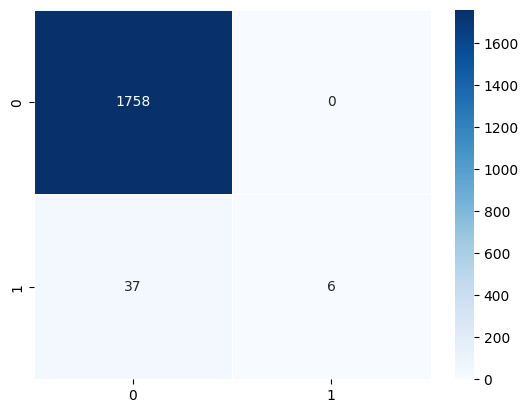

In [99]:
x_train, x_test, y_train, y_test = train_test_split(
                                          hc_data.loc[:, hc_data.columns != 'b'], 
                                          hc_data['Porucha'], 
                                          test_size=0.2, 
                                          random_state=42
                                        )

model = BayesianNetwork([("O", "Porucha")])

#s_data = hc_data[["O", "Porucha"]]
#p_data = hc_data[["O"]]



m = BayesianNetwork([("O", "Porucha"), ("K", "Porucha"), ("R", "K")])

m.fit(x_train[['O', 'Porucha', 'K', 'R']])
lst = m.predict(x_test[['O', 'K', 'R']])

metrics = ClassificationMetrics(
    real = y_test.values,
    predicted = lst['Porucha'].values,
    target_variable="Porucha"
)

print(f"Overall score: {metrics._get_overall_prob()}")

metrics._plot_conf_matrix()


  0%|          | 0/8 [00:00<?, ?it/s]

Overall score: 0.9593538301198541


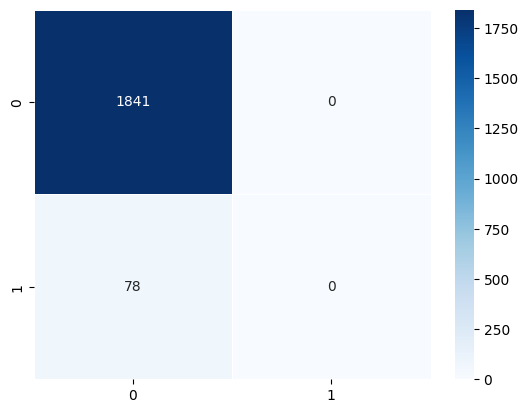

In [100]:
x_train, x_test, y_train, y_test = train_test_split(
                                          pearson_data.loc[:, pearson_data.columns != 'b'], 
                                          pearson_data['Porucha'], 
                                          test_size=0.2, 
                                          random_state=42
                                        )

model = BayesianNetwork([("O", "Porucha")])

#s_data = hc_data[["O", "Porucha"]]
#p_data = hc_data[["O"]]



m = BayesianNetwork([("O", "Porucha")])

m.fit(x_train[['O', 'Porucha', 'K', 'R']])
lst = m.predict(x_test[['O']])

metrics = ClassificationMetrics(
    real = y_test.values,
    predicted = lst['Porucha'].values,
    target_variable="Porucha"
)

metrics._get_overall_prob()

print(f"Overall score: {metrics._get_overall_prob()}")

metrics._plot_conf_matrix()


In [101]:
metrics = ClassificationMetrics(
    real = y_test.values,
    predicted = lst_1['Porucha'].values,
    target_variable="Porucha"
)

metrics._get_overall_prob()

0.9572459744586341

In [102]:
lst_1

,Porucha,K,R
0,0,2,1
1,0,2,1
2,0,2,1
3,0,2,1
4,0,2,1
...,...,...,...
1796,0,2,1
1797,0,2,1
1798,0,2,1
1799,0,2,1


In [103]:

a.groupby(by = [ 'K', 'O'], as_index = False)['Porucha'].count()['Porucha'].values / hc_data.groupby(by = [ 'K', 'O'], as_index = False)['Porucha'].count()['Porucha'].values

/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_70545/1333529941.py:1: RuntimeWarning: invalid value encountered in divide
  a.groupby(by = [ 'K', 'O'], as_index = False)['Porucha'].count()['Porucha'].values / hc_data.groupby(by = [ 'K', 'O'], as_index = False)['Porucha'].count()['Porucha'].values


array([       nan, 0.        , 0.26666667, 0.2       , 0.2       ,
              nan, 0.        , 0.        , 0.00600601, 0.07575758,
              nan, 0.        , 0.        , 0.00242326, 0.07964602,
              nan, 0.01390498, 0.00892133, 0.01240695, 0.11923077,
              nan, 0.05882353, 0.07836991, 0.11280488, 0.81395349])

In [104]:
hc_data.groupby(by = [ 'K', 'O'], as_index = False)['Porucha'].count()  

,K,O,Porucha
0,0,0,0
1,0,1,11
2,0,2,15
3,0,3,20
4,0,4,5
5,1,0,0
6,1,1,265
7,1,2,304
8,1,3,333
9,1,4,66
